# Выращиваем решающее дерево своими руками

### AIMasters 2022, "Машинное обучение 1", Алексеев Илья Алексеевич

В этом ноутбуке вам предлагается реализовать решающее дерево.

## Введение

Для начала импортируем библиотеки, которые нам понадобятся в дальнейшем:

In [ ]:
import numpy as np

from sklearn.metrics import accuracy_score

### Решающее дерево

Вспомним, что такое решающее дерево.

Решающее дерево - алгоритм машинного обучения, задающийся специальным графом-деревом. В данном задании мы будем использовать бинарное дерево. Каждая внутренняя вершина такого дерева соответствует функции предикату $\mathbb{I}[x_{\alpha} \geq \beta]$. Каждая листовая вершина соответствует некоторому значению ответа, которое будет выдавать алгоритм (вещественное число в случае регрессии, номер класса или вектор вероятностей в случае классификации).

На этапе обучения нам необходимо построить само дерево, а также выбрать $\alpha$ и $\beta$ для каждой внутренней вершины и метку прогноза для каждой листовой вершины. Задача построения "наилучшего" дерева (например того, которое не совершает ошибок и имеет минимальное число вершин) является NP-полной, поэтому при построении деревьев на практике приходиться использовать жадные алгоритмы.

На этапе применения все объекты пропускаются через дерево. Изначально, для каждого объекта вычисляется значение функции-предиката корневой вершины. Если оно равно нулю, то алгоритм переходит в левую дочернюю вершину, иначе в правую. Затем вычисляется значение предиката в новой вершине и делается переход или влево, или вправо. Процесс продолжается, пока не будет достигнута листовая вершина. Алгоритм возвращает то значение, которое будет приписано этой вершине.

### Выбор $\alpha$ и $\beta$

На этапе построения дерева мы будем выбирать предикаты для каждой новой вершины, максимизируя функционал качества для разбиения вершины на два поддерева, который можно записать в следующем виде:
$$ Q(R, \alpha, \beta) = H(R) - \frac{|R_l|}{|R|} H(R_l) - \frac{|R_r|}{|R|} H(R_r) $$

* $H$ - критерий информативности
* $R$ - объекты в текущей вершине
* $R_r$ - объекты, попадающие в правое поддерево
* $R_l$ - объекты, попадающие в левое поддерево

Например, критерий информативности Джини для задачи классификации:

$$ H(R) = \sum_{k=1}^K p_k (1 - p_k) = 1 - \sum_{k=1}^K p_k^2 $$

* $p_k$ - доля объектов с классом $k$ среди $R$
* $K$ - общее число классов

При разбиении вершины на два поддерева мы хотим максимизировать функционал качества, оптимизируя:

* $\alpha$ - номер признака в предикате
* $\beta$ - пороговое значение предиката

В данном задании оптимизацию мы будем проводить, используя полный перебор значений. Для $\alpha$ множество перебираемых значений - все имеющиеся признаки, для $\beta$ - все встречающиеся в обучающей выборке значения каждого признака, кроме наименьшего и наибольшего.

## 1. Построение критерия и вычисление предиката

В данном пункте предлагается:
- реализовать метод `get_best_split` у абстрактного класса `Criterion`, который выполняет поиск порога разбиения $\beta$ по вектору признаков;
- для каждого из критериев `GiniCriterion`, `EntropyCriterion`, `MSECriterion` реализовать два метода:
    - `score`, считает чистоту узла, т.е. непосредственно сам критерий $H(R)$;
    - `get_predict_val`, вычисляет предсказанное значение в листе.

In [ ]:
class Criterion:
    def get_best_split(self, feature, target):
        """
        Find maximum enthropy improvement which can be gained by splitting
        given objects based on given feature

        Parameters
        ----------
        feature : feature vector, np.ndarray.shape = (n_samples, )
        target  : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        threshold : value to split feature vector, float
        q_value   : impurity improvement, float
        """

        indices = np.argsort(feature)
        feature_srt = feature[indices]
        
        _, ind = np.unique(feature_srt, return_index=True)
        if len(ind) < 2:
          return None, 0
        
        N = len(feature)
        target_srt = target[indices]

        # initial improvement
        q_best = -np.inf
        i_best = None

        # initial enthropy estimation
        h_root = self.score(target)

        # greedy search for best threshold
        for i in ind[1:]:
            h_left = self.score(target_srt[:i])
            h_right = self.score(target_srt[i:])

            q = h_root - h_left * i / N - h_right * (N - i) / N

            if q > q_best:
                q_best = q
                i_best = i

        # resulting threshold is drawn between feature values,
        # corresponding to [i_best]'th and [i_best-1]'th order statistics
        thrl = (feature_srt[i_best] + feature_srt[i_best - 1]) / 2

        return thrl, q_best

    def score(self, target):
        """
        Parameters
        ----------
        target : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        impurity : float
        """

        raise NotImplementedError()

    def get_predict_val(self, target):
        """
        Parameters
        ----------
        target : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        prediction :
            - classification: probability distribution in node, np.ndarray.shape = (n_classes, )
            - regression: best constant approximation, float
        """

        raise NotImplementedError()


class GiniCriterion(Criterion):
    def __init__(self, n_classes):
        self.n_classes = n_classes

    def get_predict_val(self, classes):
        return np.bincount(classes, minlength=self.n_classes) / len(classes)

    def score(self, classes):
        pred = self.get_predict_val(classes)
        return 1 - np.sum(pred ** 2)


class EntropyCriterion(Criterion):
    EPS = 1e-6

    def __init__(self, n_classes):
        self.n_classes = n_classes

    def get_predict_val(self, classes):
        return np.bincount(classes, minlength=self.n_classes) / len(classes)

    def score(self, classes):
        pred = self.get_predict_val(classes)
        return -np.sum(pred * np.log(pred + self.EPS))


class MSECriterion(Criterion):
    def get_predict_val(self, target):
        return np.mean(target)

    def score(self, target):
        return np.var(target)

Проверь себя:

In [ ]:
target = [1, 1, 2, 4, 2, 2, 0, 1, 0, 4]
y_true = [0.2, 0.3, 0.3, 0, 0.2]
y_pred = GiniCriterion(n_classes=5).get_predict_val(target)
assert np.allclose(y_pred, y_true)

In [ ]:
target = [1, 1, 2, 4, 2, 2, 0, 1, 0, 4]
scores = GiniCriterion(n_classes=5).score(target)
assert np.isclose(scores, 0.74)

In [ ]:
N = 100

x = np.arange(N)
y = np.r_[np.ones(N // 2), np.zeros(N - N // 2)].astype(int)

threshold, q_best = GiniCriterion(n_classes=2).get_best_split(x, y)
assert np.isclose(threshold, 49.5)
assert np.isclose(q_best, 0.5)

## 2. Вычисление параметров предиката и разбиение вершины дерева

Ниже вам предлагается реализовать несколько методов. Для класса `TreeNode` необходимо реализовать методы:
* `get_best_split` - вычисление оптимальных $\alpha$, $\beta$ для выбранного функционалиа $Q(R, \alpha, \beta)$;
* `split` – разбиение узла с заданными подобранными параметрами.

In [ ]:
class TreeNode:
    def __init__(self, impurity, predict_val, depth):
        self.impurity = impurity        # node impurity
        self.predict_val = predict_val  # prediction of node
        self.depth = depth              # current node depth

        self.feature = None             # feature to split
        self.threshold = None           # threshold to split
        self.improvement = -np.inf      # node impurity improvement after split

        self.child_left = None
        self.child_right = None

    @property
    def is_terminal(self):
        return self.child_left is None and self.child_right is None

    @classmethod
    def get_best_split(cls, X, y, criterion):
        '''
        Finds best split for current node

        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        criterion : an instance of a class derived from Criterion

        Returns
        -------
        feature   : best feature to split,  int
        threshold : value to split feature, float
        q_value   : impurity improvement,   float
        '''

        q_best = -np.inf
        threshold = None
        feature = None

        # greedy search for best feature
        for i in range(X.shape[1]):
            thrl, q = criterion.get_best_split(X[:, i], y)
            if q > q_best:
                q_best = q
                threshold = thrl
                feature = i

        return feature, threshold, q_best

    def get_best_split_mask(self, X):
        '''
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)

        Returns
        -------
        right_mask : indicates samples in right node after split
            np.ndarray.shape = (n_samples, )
            np.ndarray.dtype = bool
        '''

        return X[:, self.feature] > self.threshold

    def split(self, X, y, criterion, **split_params):
        '''
        Split current node

        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        criterion : criterion to split by, Criterion
        split_params : result of get_best_split method

        Returns
        -------
        right_mask : indicates samples in right node after split
            np.ndarray.shape = (n_samples, )
            np.ndarray.dtype = bool

        child_left  : TreeNode
        child_right : TreeNode
        '''

        self.feature = split_params['feature']
        self.threshold = split_params['threshold']
        self.improvement = split_params['improvement']

        mask_right = self.get_best_split_mask(X)
        
        self.child_right = self.from_criterion(
            y[mask_right], criterion, self.depth + 1)
        self.child_left = self.from_criterion(
            y[~mask_right], criterion, self.depth + 1)

        return mask_right, self.child_left, self.child_right

    @classmethod
    def from_criterion(cls, y, criterion, depth=0):
        return cls(
            impurity=criterion.score(y),
            predict_val=criterion.get_predict_val(y),
            depth=depth,
        )


Проверьте себя:

In [ ]:
N, M = 100, 10
f = 3

criterion = GiniCriterion(n_classes=2)
x = np.c_[[np.arange(N) if f == fi else np.random.random(size=N) for fi in range(M)]].T
y = np.r_[np.ones(N // 2), np.zeros(N - N // 2)].astype(int)

In [ ]:
best_feature, best_threshold, improvement = TreeNode.get_best_split(x, y, criterion)

assert best_feature == f
assert best_threshold == 49.5
assert improvement == 0.5

## 3. Реализация дерева.

Вот мы и добрались до самого важного. В классе `DecisionTree` вам необходимо реализовать следующие методы:
* fit - обучения дерева
* predict - выдача предсказаний по дереву

Дерево предлагается строить самым простым способом – рекурсивно. Для реализации предлагается использовать два вспомогательных метода: 
* `_build_nodes` - вспомогательный рекурсивный метод для fit, разделяет вершину на две, если не выполняются условия останова;
* `_get_nodes_predictions` - вспомогательный рекурсивный метод для predict, пропускает объекты через вершины и заполняет матрицу предсказаний.

Важный вопрос при реализации: как выбрать критерий останова создания новой вершины?

Вершина не будет разветвляться, если выполнено хотя бы одно из четырех условий:
* если вершина на глубине `max_depth`;
* если в вершине меньше, чем `min_leaf_size` объектов;
* если в вершине все объекты имеют одинаковые метки;
* если функционал качества не увеличивается больше, чем на `min_improvement`.

Также для интерпретации важности признаков, участвующих в построении дерева, предлагается реализовать метод-свойство `feature_importances_`.

In [ ]:
from collections import deque


class DecisionTree:
    def __init__(self,
                 max_depth=None,
                 min_leaf_size=None,
                 min_improvement=None):
        self.criterion = None
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.min_improvement = min_improvement

    def _build_nodes(self, X, y, criterion, indices, node):
        '''
        Builds tree recursively

        Parameters
        ----------
        X : initial dataset, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        criterion : criterion to split by, Criterion
        indices : samples' indices in node,
            np.ndarray.shape = (n_samples, )
            nd.ndarray.dtype = int
        node : current node to split, TreeNode
        '''

        if (self.max_depth is not None) and (node.depth >= self.max_depth):
            node.predictions = criterion.get_predict_val(y[indices])
            return

        if (self.min_leaf_size is not None) and \
           (len(indices) < self.min_leaf_size):
            node.predictions = criterion.get_predict_val(y[indices])
            return

        if np.unique(y[indices]).shape[0] < 2:
            node.predictions = criterion.get_predict_val(y[indices])
            return

        # objects reached current node
        X_node = X[indices]
        y_node = y[indices]

        # minimize current enthropy
        feature, threshold, improvement = node.get_best_split(X_node,
                                                              y_node,
                                                              criterion)

        if (self.min_improvement is not None) and \
           (improvement < self.min_improvement):
            node.predictions = criterion.get_predict_val(y[indices])
            return

        mask_right, child_left, child_right = node.split(
            X_node, y_node, criterion,
            feature=feature,
            threshold=threshold,
            improvement=improvement
        )

        # len(indices) == len(X_node)
        # => mask_right also corresponds to indices
        self._build_nodes(X, y, criterion,
                          indices[~mask_right], child_left)
        self._build_nodes(X, y, criterion,
                          indices[mask_right], child_right)

    def _get_nodes_predictions(self, X, predictions, indices, node):
        '''
        Builds tree recursively

        Parameters
        ----------
        X : intial dataset, np.ndarray.shape = (n_samples, n_features)
        predictions : result matrix to be feild,
            - classification : np.ndarray.shape = (n_samples, n_classes)
            - regression : np.ndarray.shape = (n_samples, )
        indices : samples' indices in node,
            np.ndarray.shape = (n_samples, )
            nd.ndarray.dtype = int
        node : current node to split, TreeNode
        '''

        if node.is_terminal:
            predictions[indices] = node.predictions
            return

        X_node = X[indices]
        mask_right = node.get_best_split_mask(X_node)

        # len(indices) == len(X_node)
        # => mask_right also corresponds to indices
        self._get_nodes_predictions(X, predictions,
                                    indices[~mask_right], node.child_left)
        self._get_nodes_predictions(X, predictions,
                                    indices[mask_right], node.child_right)

    @property
    def feature_importances_(self):
        '''
        Returns
        -------
        importance : cummulative improvement per feature,
                     np.ndarray.shape = (n_features, )
        '''

        importance = np.zeros(self.n_features_)
        queue = deque()
        queue.append(self.root_)

        while queue:
            node = queue.popleft()
            if node.is_terminal:
                continue

            importance[node.feature] += node.improvement
            queue.append(node.child_left)
            queue.append(node.child_right)

        return importance


А теперь на основе реализованного в общем виде дерева, сделаем дерево для классификации:

In [ ]:
class ClassificationDecisionTree(DecisionTree):
    def __init__(self, criterion='gini', **kwargs):
        super().__init__(**kwargs)
        
        if criterion not in ('gini', 'entropy', ):
            raise ValueError('Unsupported criterion', criterion)
        self.criterion = criterion
            
    def fit(self, X, y):
        self.n_classes_ = np.max(y) + 1
        self.n_features_ = X.shape[1]
        
        if self.criterion == 'gini':
            criterion = GiniCriterion(n_classes=self.n_classes_)
        elif self.criterion == 'entropy':
            criterion = EntropyCriterion(n_classes=self.n_classes_)
        else:
            raise ValueError('Unsupported criterion', criterion)

        self.root_ = TreeNode.from_criterion(y, criterion)
        self._build_nodes(X, y, criterion, np.arange(X.shape[0]), self.root_)

        return self
    
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)
    
    def predict_proba(self, X):
        probas = np.zeros(shape=(X.shape[0], self.n_classes_))
        self._get_nodes_predictions(X, probas, np.arange(X.shape[0]), self.root_)
        return probas

Проверь себя:

In [ ]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)

some_X = np.vstack((
    np.random.normal(loc=(-5, -5), size=(100, 2)),
    np.random.normal(loc=(-5, 5), size=(100, 2)),
    np.random.normal(loc=(5, -5), size=(100, 2)),
    np.random.normal(loc=(5, 5), size=(100, 2)),
))

some_y = np.array(
    [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100
)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

In [ ]:
some_X.shape, some_y.shape

((400, 2), (400,))

In [ ]:
assert isinstance(predictions, type(np.zeros(0)))
assert (predictions == some_y).all()

In [ ]:
assert (some_tree.feature_importances_ == [0.25, 1.  ]).all()

Ещё одна проверка:

In [ ]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)

some_X = np.vstack((
    np.random.normal(loc=(-5, -5), size=(100, 2)),
    np.random.normal(loc=(-5, 5), size=(100, 2)),
    np.random.normal(loc=(5, -5), size=(100, 2)),
    np.random.normal(loc=(5, 5), size=(100, 2)),
))

some_X = np.hstack((some_X, np.random.random((400, 100))))

some_y = np.array(
    [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100
)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

In [ ]:
assert isinstance(predictions, type(np.zeros(0)))
assert (predictions == some_y).all()

## 4. Визуализация результатов

Давайте проверим, что дерево работает на нескольких модельных задачах.

In [ ]:
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
%matplotlib inline

Функция для визуализации двумерной выборки:

In [ ]:
def plot_data(X, y, figsize=(6, 5)):
    plt.figure(figsize=figsize)
    
    n_classes = y.max() + 1
    for i in range(n_classes):
        plt.plot(X[:, 0][y == i], X[:, 1][y == i], 'o')

Функция для визуализации работы дерева на двумерной выборке:

In [ ]:
def plot_decision_surface(clf, X, y, plot_step=0.2, cmap='Spectral', figsize=(6, 5)):
    # Plot the decision boundary
    plt.figure(figsize=figsize)
    
    n_classes = len(set(y))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)    
    y_pred = clf.predict(X)

    # Plot the training points
    plt.scatter(*X[y_pred == y].T, marker='.', s=70,
                c=y[y_pred == y], cmap=cmap, alpha=0.9, label='correct')
    plt.scatter(*X[y_pred != y].T, marker='x', s=50,
                c=y[y_pred != y], cmap=cmap, label='errors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")
    plt.legend(loc='best')
    print("Accuracy =", accuracy_score(y, y_pred))

Для начала рассмотрим простую задачу с полностью разделимыми по некоторому признаку классами:

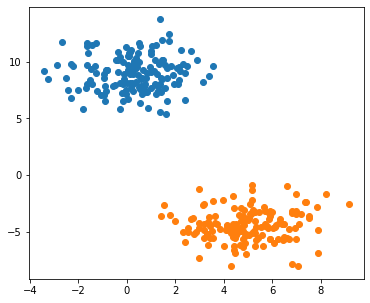

In [ ]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=1.5, centers=2, random_state=23)

plot_data(X, y)

Применим к этой задаче алгоритм "решающий пень":

In [ ]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

Если вы всё реализовали правильно, то должно получиться что-то такое:

Accuracy = 1.0


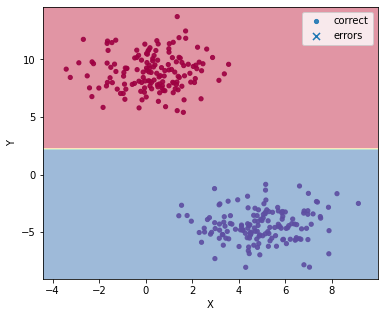

In [ ]:
plot_decision_surface(some_tree, X, y)

Теперь рассмотрим более сложную задачу с плохо разделимыми классами:

In [ ]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=2, centers=5, random_state=23)

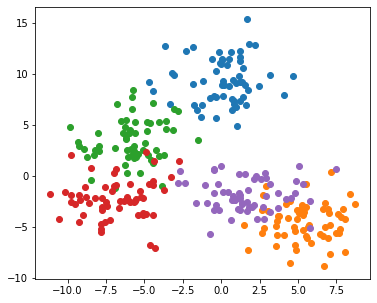

In [ ]:
plot_data(X, y)

Посмотрим на результаты, которые получаются при разных значениях глубины:

Accuracy = 0.4


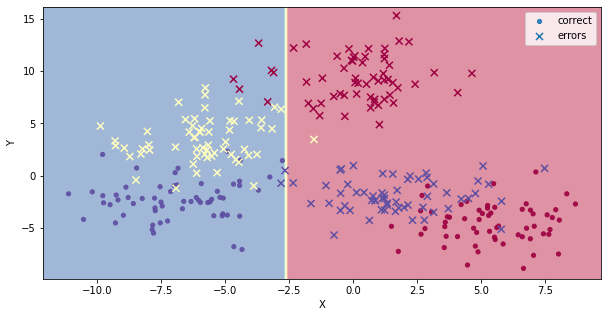

In [ ]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.7466666666666667


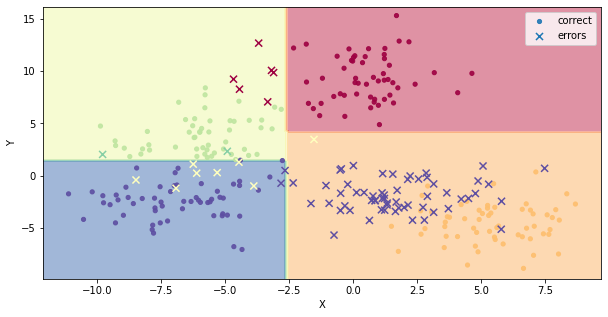

In [ ]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.89


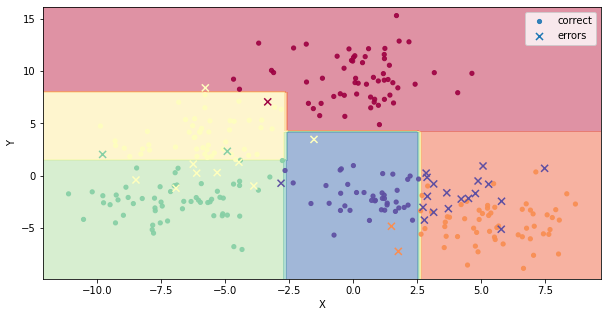

In [ ]:
some_tree = ClassificationDecisionTree(max_depth=3, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.94


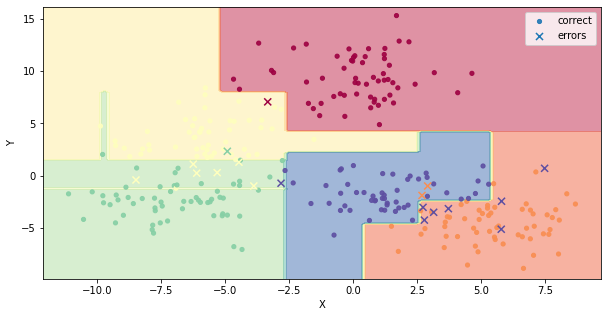

In [ ]:
some_tree = ClassificationDecisionTree(max_depth=5, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 1.0


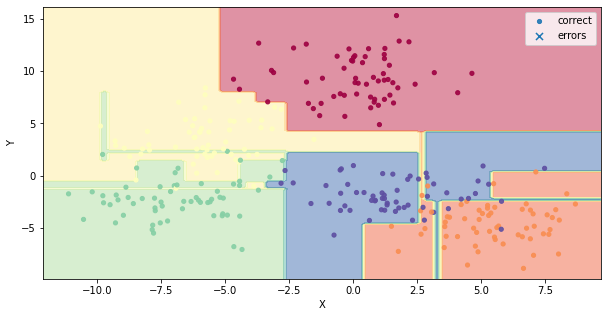

In [ ]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Можно заметить, что начиная с некоторого значения глубины, дерево начинает сильно переобучаться (новые сплиты пытаются описать максимум 1-2 объекта). Это можно поправить, изменяя параметр `min_leaf_size` или `min_improvement`.

Accuracy = 0.95


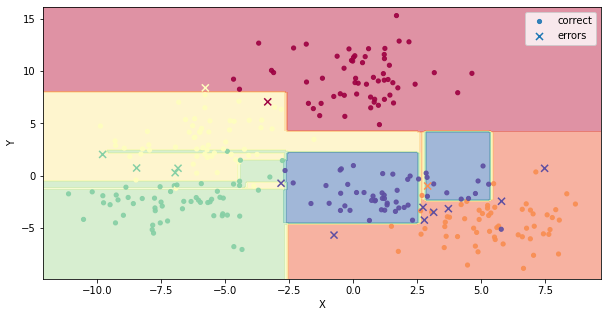

In [ ]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=10)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.92


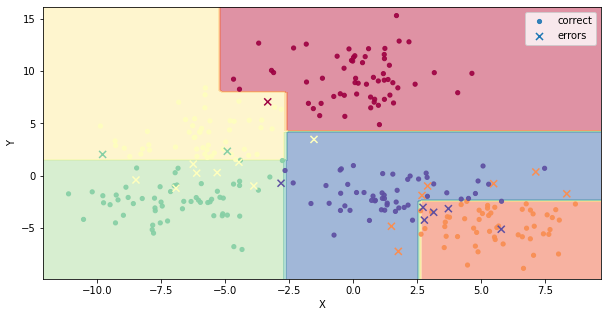

In [ ]:
some_tree = ClassificationDecisionTree(max_depth=10, min_improvement=0.08)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

## Домашнее задание (10 баллов)

1. (4 балла) Доделать все пункты ноутбука до конца

2. (2 балла) Для регрессионного дерева необходимо использовать такой критерий:

$$H(R) = \min_c \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - c)^2$$

Докажите, что минимум H(R) достигается при $c$:

$$ c = \frac{1}{|R|} \sum_{(x_j, y_j) \in R} y_j$$

3. (2 балла) Реализуйте регрессионное дерево. В качестве критерия необходимо использовать критерий, определённый в пункте 2. В качестве функции выдачи результатов необходимо использовать среднее значение ответов по всем объектам в листе.

    Сгенерируйте однопризнаковую выборку для тестирования дерева и покажите работу дерева на этой выборке. Отобразите на одном графике значения алгоритма и точки. Нарисуйте эту картинку для нескольких значений глубины. Сделайте выводы.
    
    
3. (2 балла) Протестируйте ваше дерево на california_housing датасете (можно загрузить с помощью sklearn.datasets.fetch_california_housing).
    Разбейте данные на обучение, контроль и тест. Подберите гиперпараметры по контрольной выборке, покажите качество алгоритма на тестовой. Сделайте выводы.


Бонусных баллов в этот раз нет :)

### Регрессионное дерево

In [ ]:
class RegressionDecisionTree(DecisionTree):
    def __init__(self, criterion='mse', **kwargs):
        super().__init__(**kwargs)
        
        if criterion not in ('mse', ):
            raise ValueError('Unsupported criterion', criterion)
        self.criterion = criterion
            
    def fit(self, X, y):
        self.n_features_ = X.shape[1]
        
        if self.criterion == 'mse':
            criterion = MSECriterion()
        else:
            raise ValueError('Unsupported criterion', criterion)

        self.root_ = TreeNode.from_criterion(y, criterion)
        self._build_nodes(X, y, criterion, np.arange(X.shape[0]), self.root_)

        return self
    
    def predict(self, X):
        values = np.zeros(X.shape[0])
        self._get_nodes_predictions(X, values, np.arange(X.shape[0]), self.root_)
        return values

### Рисунки на плоскости

In [ ]:
import seaborn as sns
sns.set(palette='deep', style='darkgrid')
def plot_regression(reg, X, y, step_count=100, figsize=(6, 5)):
    # Plot the decision boundary
    plt.figure(figsize=figsize)

    reg.fit(X, y)
    xmin, xmax = X.min(), X.max()
    x_test = np.linspace(xmin, xmax, step_count).reshape(-1, 1)
    y_test = reg.predict(x_test)

    # Plot the training points
    plt.plot(x_test, y_test, label='Predicted', alpha=0.75)
    plt.scatter(X, y, marker='.', s=50, label='Sample', c='indigo')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")
    plt.legend(loc='best')
    plt.title(f'max depth: {reg.max_depth}')
    # print("MSE =", (y_test y_pred))

In [ ]:
def make_regression(func, a, b, n_samples, noise):
    X = np.linspace(a, b, n_samples)
    y = func(X) + np.random.normal(scale=noise, size=n_samples)
    return X.reshape(-1, 1), y
X, y = make_regression(np.sin, a=-np.pi, b=np.pi, n_samples=50, noise=0.2)

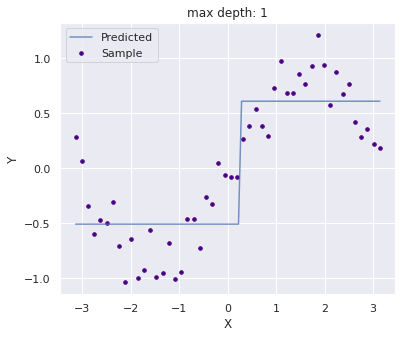

In [ ]:
reg = RegressionDecisionTree(max_depth=1)
plot_regression(reg, X, y)

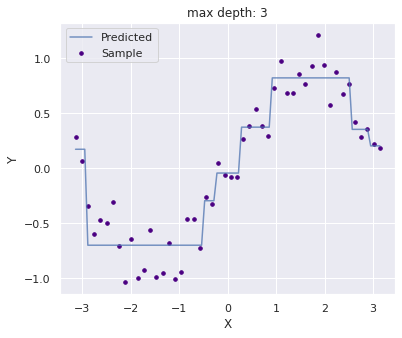

In [ ]:
reg = RegressionDecisionTree(max_depth=3)
plot_regression(reg, X, y)

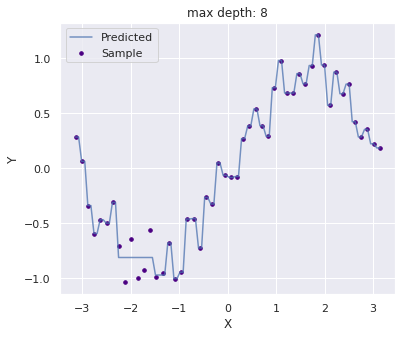

In [ ]:
reg = RegressionDecisionTree(max_depth=8)
plot_regression(reg, X, y)

#### Выводы

Дерево решений чувствительно к выбору параметра `max_depth`, поскольку при достаточно большом значении глубины дерево полностью переобучается.

### California Housing

#### Подбор параметров

In [ ]:
from sklearn.datasets import fetch_california_housing as california_housing
X, y = california_housing(return_X_y=True)
type(X), type(y), X.shape, y.shape

(numpy.ndarray, numpy.ndarray, (20640, 8), (20640,))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
import optuna


def objective(trial):
  params = {
    'max_depth': trial.suggest_int('max_depth', 1, 30),
    'min_leaf_size': trial.suggest_int('min_leaf_size', 0, 300),
    # 'min_improvement': trial.suggest_float('min_improvement', 1e-5, 1e1, log=True)
  }
  reg = RegressionDecisionTree(**params)
  reg.fit(X_train, y_train)
  y_pred = reg.predict(X_val)
  score = np.mean((y_pred - y_val) ** 2)
  return score

def start_optimization(
    objective_func,
    n_trials,
    n_jobs,
    study_direction=None,
    study_directions=None,
    sampler=None,
    **data_kwargs
):

  study = optuna.create_study(sampler=sampler,
                              direction=study_direction,
                              directions=study_directions)

  study.optimize(objective_func, n_trials=n_trials, n_jobs=n_jobs)
  return study

In [ ]:
# gamma = lambda n_trials: min(int(np.ceil(0.1 * n_trials)), 3)
tpe_sampler = optuna.samplers.TPESampler(n_startup_trials=20)

optuna_args = {
    'objective_func': objective,
    'n_trials': 50,
    'n_jobs': 4,
    'study_direction': 'minimize',
    'sampler': tpe_sampler
}

# optuna.logging.disable_default_handler()
study = start_optimization(**optuna_args)

[I 2022-12-06 15:49:12,416] A new study created in memory with name: no-name-0ab4d30d-6e8b-42c6-aaba-31760688e7c4
[I 2022-12-06 15:52:57,161] Trial 1 finished with value: 0.39061869109408515 and parameters: {'max_depth': 10, 'min_leaf_size': 212}. Best is trial 1 with value: 0.39061869109408515.
[I 2022-12-06 15:52:58,238] Trial 3 finished with value: 0.40625527203125106 and parameters: {'max_depth': 28, 'min_leaf_size': 287}. Best is trial 1 with value: 0.39061869109408515.
[I 2022-12-06 15:53:03,284] Trial 0 finished with value: 0.3868688236538702 and parameters: {'max_depth': 25, 'min_leaf_size': 231}. Best is trial 0 with value: 0.3868688236538702.
[I 2022-12-06 15:53:23,041] Trial 2 finished with value: 0.47995279329761464 and parameters: {'max_depth': 13, 'min_leaf_size': 0}. Best is trial 0 with value: 0.3868688236538702.
[I 2022-12-06 15:56:41,417] Trial 4 finished with value: 0.3840244122850533 and parameters: {'max_depth': 16, 'min_leaf_size': 201}. Best is trial 4 with value

In [ ]:
def clipper_example(frozen_trial):
    max_value = 0.4
    return min(frozen_trial.value, max_value)

optuna.visualization.plot_contour(study, target=clipper_example, target_name='MSE')

In [ ]:
study.best_params, study.best_value

({'max_depth': 19, 'min_leaf_size': 83}, 0.36888826588361184)

Оптимальный размер листа: около 80-90. При других значениях одинаково сильная потеря качества.

Оптимальная глубина: 19-20. При меньшем значении потеря качества значительнее, чем при больших.

#### Тест

In [ ]:
reg = RegressionDecisionTree(min_improvement=None, **study.best_params)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
np.mean((y_pred - y_test) ** 2)

0.3831463636733926

Финальное качество: 0.3831.